# Nov 6
- I'm starting to log my progress and process for this thesis.
- I'm currently thinking of how to get HER to work from images without introducing additional models that have to be learned.
- My current approach is to reuse the latent space generated by the convolutional encoder used by the actor and critic.
- I'm checking if distance to resampled goals in the latent space is a good proxy for the true reward.
- I'm fitting a logistic regression curve onto a plot where x is latent distance to resampled goal and y is the recomputed reward to see if there's a clear correlation. 

Below is code for collecting the latent distances and corresponding rewards for 10 rollouts from the environment.

In [1]:
import torch
import gym
import numpy as np

import wrappers
import buffer as buffers
import agent

def collect_deltas_and_rewards(env_id):
    env = wrappers.ImageEnv(gym.make(env_id))
    buffer = buffers.ReplayBuffer(True, env.observation_space, env.action_space, 1_000_000, 'cpu')
    encoder = agent.ConvolutionalEncoder(env.observation_space, 32)

    recomputed_rewards = []
    deltas = []

    for t in range(10):
        image_observations = []
        image_achieved_goals = []
        image_desired_goals = []

        observations = []
        achieved_goals = []
        desired_goals = []

        rewards = []

        obs_dict = env.reset()
        while True:
            action = env.action_space.sample()
            obs_dict, reward, done, info = env.step(action)

            image_observations.append(obs_dict['image_observation'])
            image_achieved_goals.append(obs_dict['image_achieved_goal'])
            image_desired_goals.append(obs_dict['image_desired_goal'])

            observations.append(obs_dict['observation'])
            achieved_goals.append(obs_dict['achieved_goal'])
            desired_goals.append(obs_dict['desired_goal'])

            rewards.append(reward)

            if done:
                break

        image_observations = torch.as_tensor(np.asarray(image_observations))
        image_achieved_goals = torch.as_tensor(np.asarray(image_achieved_goals))
        image_desired_goals = torch.as_tensor(np.asarray(image_desired_goals))

        latent_observations = encoder.forward_single_observation(image_observations).detach().numpy()
        latent_achieved_goals = encoder.forward_single_observation(image_achieved_goals).detach().numpy()
        latent_desired_goals = encoder.forward_single_observation(image_desired_goals).detach().numpy()

        for transition in range(len(observations)-1):
            for future_goal in range(transition+1, len(observations)):
                achieved_goal = achieved_goals[transition+1]
                desired_goal = achieved_goals[future_goal]
                recomputed_reward = env.compute_reward(achieved_goal, desired_goal, dict())

                # distance to resampled goal in latent image space
                latent_deltas = np.linalg.norm(latent_achieved_goals - latent_achieved_goals[future_goal], axis=-1)
                # normalize to check z score
                latent_deltas = (latent_deltas - latent_deltas.mean())/latent_deltas.std()
                delta = latent_deltas[transition]

                recomputed_rewards.append(recomputed_reward)
                deltas.append(delta)

    recomputed_rewards = np.asarray(recomputed_rewards)
    deltas = np.asarray(deltas)
    
    return recomputed_rewards, deltas

Below we collect dense rewards from `FetchReachDense-v1` and fit a linear regression model:

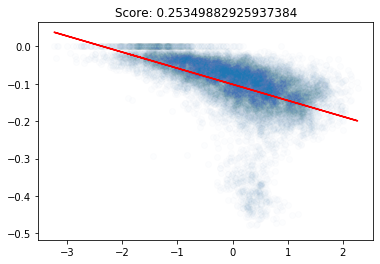

In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt
from sklearn import linear_model

recomputed_rewards, deltas = collect_deltas_and_rewards("FetchReachDense-v1")

clf = linear_model.LinearRegression()
clf.fit(deltas.reshape(-1, 1), recomputed_rewards)
y_test = clf.predict(deltas.reshape(-1, 1))

plt.scatter(x=deltas, y=recomputed_rewards, alpha=0.01)
plt.plot(deltas, y_test, color='r')
plt.title(f'Score: {clf.score(deltas.reshape(-1, 1), recomputed_rewards)}')
plt.show()

Below we collect sparse rewards from `FetchReach-v1` and fit a logistic regression model.

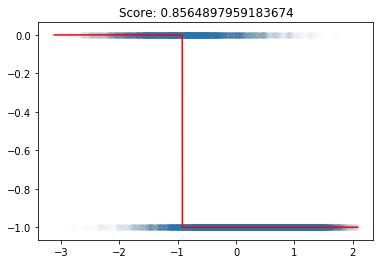

In [3]:
recomputed_rewards, deltas = collect_deltas_and_rewards("FetchReach-v1")

clf = linear_model.LogisticRegression()

deltas, recomputed_rewards = np.sort(deltas), recomputed_rewards[np.argsort(deltas)]

clf.fit(deltas.reshape(-1, 1), recomputed_rewards)
y_test = clf.predict(deltas.reshape(-1, 1))
y_test = (y_test - y_test.min())/(y_test.max() - y_test.min()) * (recomputed_rewards.max() - recomputed_rewards.min()) + recomputed_rewards.min()

plt.scatter(x=deltas, y=recomputed_rewards, alpha=0.01)
plt.plot(deltas, y_test, color='r')
plt.title(f'Score: {clf.score(deltas.reshape(-1, 1), recomputed_rewards)}')
plt.show()

In [ ]:
import sklearn.metrics

In [ ]:
sklearn.metrics.confusion_matrix(recomputed_rewards, y_test)

- This seems to show that we can use a threshold of "normalized latent distance < -1 std gives a reward of 0" as a parameter-free reward function.

- One important note about this approach is that it is designed to work with HER (post-hoc relabeling of goals and recomputing rewards) and with SAC. We only use rewards to train the critic from the replay buffer, so we can ignore the reward the agent gets "in the environment" and just compute the actual targets for the critic at a later time (in this case when we move a rollout from the episode buffer to the full replay buffer).
- The reward in the environment is ignored by the agent.

Nov 9 2020
- I am running a rollout on `FetchReach-v1` and `FetchReachDense-v1` using the approach above - if the latent distance to the goal has a z score less than -1 then we give a reward of 0. 
- I am also going to run a rollout using just the negative latent distance to the goal under the git branch "reward_latent_to_goal"

- I edite the HindsightReplayBuffer to use online goal sampling instead of only ever picking `num_resampled_goals` goals at storage time, thus increasing the diversity and decreasing the memory footprint.

Nov 10 2020
- I'm going to look at the results of the grid search:

- It looks like this got cut off early, since it should have gone to 20k time steps. I'm going to re-run a smaller grid search now, only looking at the learning rate and number of resampled goals as hyperparameters.

- I'm also going to try to use the target critic encoder to encode features, since that network gets updated slower and the resulting features shouldn't change as quickly!

- The next things I really have to work on are:
  - reproducibility from random seeds (is it mocap failure?)
  - averaging over multiple random seeds/runs given fixed hyperparameters


- Eventually I want to add in sampling goals by checking critic disagreement.

- While waiting for grid searches to run, I began working on reproducibility.
  - Action spaces need to be seeded separately (I made a simple env wrapper where calling `seed()` seeds both the env and the action space).
  - There are enough mocap steps that state observations/goals are essentially identical (passes `np.allclose`).
  - For some reason, the camera images are totally different with the same random seed (position and angle relative to the robot). I'll have to look into this more.

**the code below used to produce different images until I added the "FixedViewerWrapper"**

In [4]:
from agent import Agent
import wrappers
import gym
from PIL import Image
import utils
import numpy as np

SEED = 0

utils.set_seed_everywhere(SEED)
env1 = gym.make("FetchReach-v1")
env1 = wrappers.DeterministicWrapper(env1, SEED)
env1 = wrappers.FixedViewerWrapper(env1)
env1 = wrappers.ImageEnv(env1)
env1 = wrappers.DoneOnSuccessWrapper(env1)
agent1 = Agent(from_images=True, observation_space=env1.observation_space, action_space=env1.action_space)
env1 = wrappers.LatentDistanceRewardEnv(env1, agent1)

env1.reset()
obs_dict1, rew1, done, info = env1.step(env1.action_space.sample())



utils.set_seed_everywhere(SEED)
env2 = gym.make("FetchReach-v1")
env2 = wrappers.DeterministicWrapper(env2, SEED)
env2 = wrappers.FixedViewerWrapper(env2)
env2 = wrappers.ImageEnv(env2)
env2 = wrappers.DoneOnSuccessWrapper(env2)
agent2 = Agent(from_images=True, observation_space=env2.observation_space, action_space=env2.action_space)
env2 = wrappers.LatentDistanceRewardEnv(env2, agent2)

env2.reset()
obs_dict2, rew2, done, info = env2.step(env2.action_space.sample())

# identical initialization
for p1, p2 in zip(agent1.critic.parameters(), agent1.critic.parameters()):
    assert((p1 == p2).all().item())

for p1, p2 in zip(env1.encoder.parameters(), env2.encoder.parameters()):
    assert((p1 == p2).all().item())
    
assert(np.allclose(obs_dict1['observation'], obs_dict2['observation']))
assert(np.allclose(obs_dict1['achieved_goal'], obs_dict2['achieved_goal']))
assert(np.allclose(obs_dict1['desired_goal'], obs_dict2['desired_goal']))

diff = obs_dict1['image_observation'] - obs_dict2['image_observation']

TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
env1.unwrapped._get_viewer('rgb_array')

In [ ]:
env1.unwrapped.viewer

In [ ]:
display(Image.fromarray(obs_dict1['image_observation'].T).resize((512, 512)))

In [ ]:
display(Image.fromarray(obs_dict2['image_observation'].T).resize((512, 512)))

For some reason the camera initializations are different.

- Also, side note - training and eval success seem to be very different:

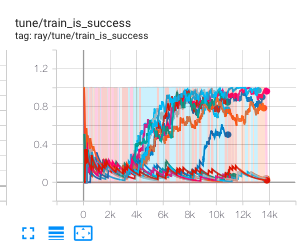

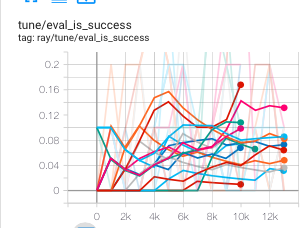

This could potentially be due to sampling vs not sampling for actions in a way that the agent relies on stochasticity, or something else entirely. Will have to debug that later.


As part of a solution, I should make:
- a VideoWrapper to automatically record stuff (in a new thread..?)
- a MultiWrapper that lets me wrap all of the wrappers onto the env, and lets me set the encoder after the fact since the agent needs the env and the env needs the agent.

- My small grid search using the critic encoder, and my duplicate but using target critic encoder have finished.

- This is the critic encoder:

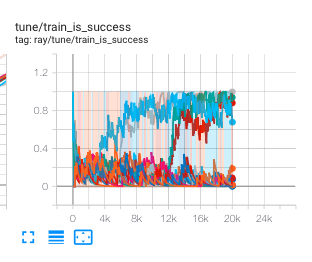

And this is the target critic encoder, which seems to be much more stable and likely to be successful.

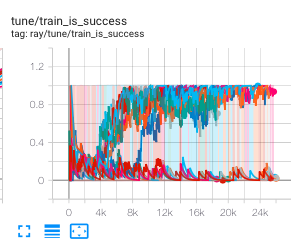

- I originally wanted this to work by not adding any extra parameters. But it might be even easier to learn if I just copy the initial critic encoder, since the agent always has to overcome the drop in performance that happens once the critic updates for the first few times and its latent distribution changes drastically (at the 1k mark, once updates start).
- We could just copy the encoder completely at the beginning and never change it, in which case we would have something similar to RND.
- I'm running the same grid search again as for the target critic encoder, but with a modified `eval()` function which hopefully fixes the wonkiness.
  - I made evaluations happen between training episodes.
  - I allowed sampling actions during evaluation. (need to test reliance on stochasticity)
- I also need to see if it can still learn when I remove the `DoneOnSuccessWrapper` since it would be nice if it stayed at the goal position. It will likely take longer to learn, but will be more impressive.

Nov 11
- So it turns out that just straight using the initial encoder is not helpful since the extracted features aren't yet meaningful.
- Instead, using the target critic encoder seems to be the best bet. While the features change (and thus the reward function is nonstationary), the agent seems to be capable of learning.
- One option to try would be to clip the reward into a certain range (perhaps applying layer norm to output...?)
- I say this because the critic loss tends to go up while success rate also goes up.

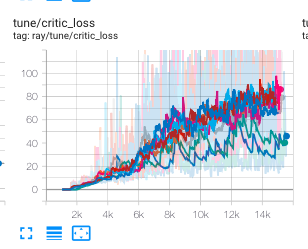

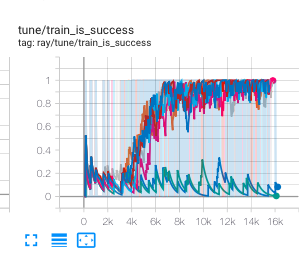

- Unfortunately, this method seems to have high variability since the bottom badly performing lines are actually using the same seed and hyperparameters... Just a different sample.

In [5]:
tune.Analysis('logs/fixed_eval').get_best_config(metric='train_is_success', mode='max')

NameError: name 'tune' is not defined

In [6]:
tune.Analysis('logs/fixed_eval').get_best_config(metric='train_is_success', mode='min')

NameError: name 'tune' is not defined

- One thing that I will note is that I can probably just run this for much longer (100k steps) and get good results, since it still appears to be learning in terms of reward.
- Clipping the reward will also in turn allow me to clip the target values, making the critic learning easier and hopefully stabilizing the outputs.
- If we always normalize feature vectors to be unit norm, then since $\| x - y \| \leq \| x \| + \| y \|$. Therefore, the reward is now bounded by $-2 \leq r \leq 0$. We can bound the return using the formulat for an infinite geometric series: $ \frac{-2}{1-\gamma} \leq R \leq 0$. We can then clip the critic target values into this range to help stabilize learning.

- The goal with clipping rewards and critic targest would be to stabilize the learning and reduce variability.

- Alright so I tried the critic clipping and feature vector normalization and I would say that idea doesn't seem to work very well for one reason or another.
- The agent seems capable of learning the task even if the critic loss blows up.

This is the critic loss, which is definitely smaller:

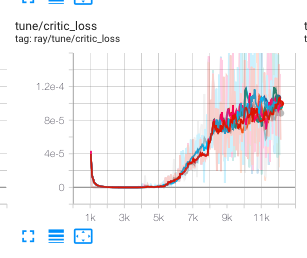

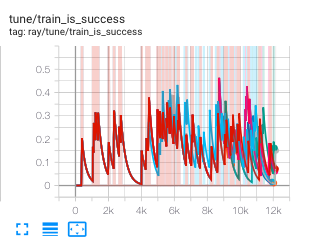

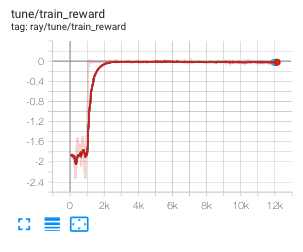

- I think that the normalization procedure removes information about how different images are.
- One thing I could do is to stabilize the critic a bit more by clipping targets to be below 0.

- I'm going to try that, removing latent vector normalization and clipping the target Q values below 0.

- I also still need to test evaluation without stochasticity.

Also, clipping the critic targets to be below 0 seems to help so far:

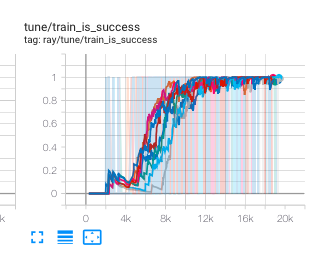

Nov 12

- Uhhh I don't know what I did but the results are looking crappy again...

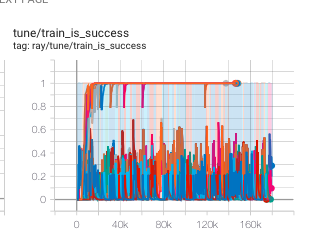

I need to figure out what happened.

- I'm removing the minor changes I made to `eval()` (which shouldn't matter anyways) and re-running it. I think that this method just has high variability, so I need to add some ways to keep the variability low. I could try clipping the reward somehow (and not just the critic targets).
- One thing I need to test is
  - What do the output features look like?
  - What is their distribution?
  - What do the rewards look like as a function of the features?
  - How does the number of feature dimensions change the performance?
- Again, I also need to aggregate performance measures. 
- I need to make evaluation based on time steps and not based on episodes, since episodes get shorter.
- I need to know how ray tune interacts with mpi.

Nov 13
- So it looks like higher feature_dim results in higher success rate:
- Feature_dim=16:

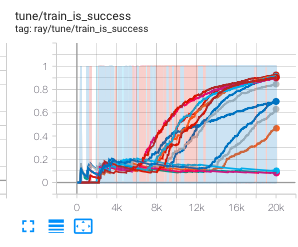

- Feature_dim=32:

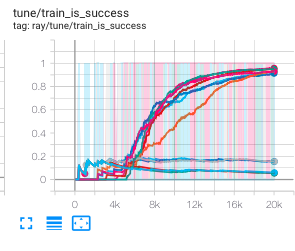

- Feature_dim=64:

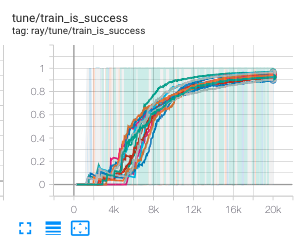

- Feature_dim=128:

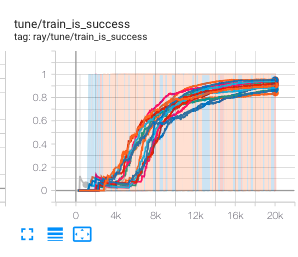

- It seems like 64-128 dims is sufficient for good performance

- This is good since I don't need to add more code for stability, like gradient or reward clipping - simply increasing the expressivity of the latent space is sufficient.

- I guess now I can move on to critic-disagreement-for-novelty!

- So what I will need is:
  - A GoalSamplingBuffer that just stores observation images
  - The critic disagreement should be computed online (could be done in a batch), rather than computed at observation time and stored (since those disagreement scored will become outdated as the critics learn).
  - Will need a way of looking at pictures of goals and determining how hard they are to reach
  - Maybe write a CurriculumGoalWrapper that samples goals with some level of difficulty based on distance from initial gripper position...?
  - Or just a function that can generate goals of varying difficulty and I can generate the images using the code from ImageEnv and then look at critic disagreement vs difficulty.
  - I should probably also include code for pretty displaying of this information
  - Maybe I can have a set of fixed "evaluation" goals with varying difficulty and then just use those over time.

- I added a `get_goal_image` method to `utils.py` which is just a copy-paste of `_set_to_goal` for now that also renders and returns an image. I'm going to toy around and hand-pick some good goals for debugging that are easy to hard (maybe 10 of them?)

Some notes missing but I will update them

- I ran from images just to see what would happen (not correct lighting or angle or anything, and it showed similar learning curve to simulation code:
  - Steep drop at 1k as critic updates, then swift recovery and steady increase in reward
  - When I loaded up the webcam the robot seemed to be stuck in a position that it couldnt reset from
  

- I have to put the code back into make it return correctly via an action and threading but for now, doing `time.sleep` seems to be enough

Nov 19
- I went to go run the code overnight but when I woke up I found out that I didn't have ffmpeg imageio installed to create the videos during eval so it stopped running early on. I fiedx that and am re=running again. Im running just from states and am using a simplified version (xyz coordinates).

- So far it's looking good! 100% success rate while training by 2k steps

- Hmmm, episodes seem to only consist of a single timestep though. I wonder why that is. Maybe it is just capable of moving there in a single step?

- Oh duh... I ran it with `fix_goals=True`! Now I have to run it without fixed goals since I can see that it works.

- It actually also seems to work without the fixed goals. 
- The video that gets recorded during evaluation is really choppy, I wonder if there's a good way to fix that. It would definitely be awkward.
- I also wonder how well it would work if I further constrained action sizes to be smaller than 5cm, like maybe 2cm.
- I also need to go into the office and set up the tripod to record the robot arm. 
- I also need to write the code to save the learned model so I can open it and run it. I should probably write code for saving/restoring so that I can arbitrarily restore training or do evaluation, and write it into the main training loop so that it just saves and restarts itself every 1000 steps or something.

- I also need to add some robustification to the robot, maybe by adding a bit of noise to the observations. 

- It may also be worth "setting the goal" by sampling a goal, going to the desired state, then actually recording the ACTUAL goal achieved?

Nov 20
- It looks like where I expect to end up and where I really end up from `_set_to` is off, and I may not be waiting long enough. I'm going to increase waiting time.

- I just found a bug in my code for `_set_to` which had the wrong duration to wait. I fixed that. I'll re-run my code from states again now.

- Not waiting long enough during eval, need to add (not mul) time

- So I changed two things:
  1. The way we wait for actions to complete is by adding 1 second to the estimated wait time rather than multiplying by 2. This way even very short actions have enough time to start/stop.
  2. When calling `_set_to`, the duration was being computed wrong: it was computed using the distance from the current position to the home position (rather than to the desired position). I fixed this.

- It seems to be learning, but I notice that near the boundary, actions keep trying to push beyond the boundary zones. It's possible that the goals are somehow generated outside of the allowed region.

Nov 23
- I started to run the robot from images on the reach task. It hasn't been running long enough to see solid progress but it seems to be doing well - the training reward (latent distance to goal) is improving quickly in the first two thousands steps of training.
- I need to implement model saving and loading as well as experiment restoration.

- I'll probably test that on Koios with the simulation env.

- To make the whole thing serializable, I have to implement `save` and `load` methods on all relevant objects. This includes:
  - Agent
  - ReplayBuffer
  - Experiment
  - Env (?)

Nov 24
- I only needed to implement saving and loading in the `Experiment` class. I updated `run.py` to work from command line args (no support for automatic grid search yet but that should be fine with `action='append'`). Saving and loading can be helpful in the event of a crash.
- By 10K steps, running from images on the real robot did not seem to work. The reward definitely got higher but the success rate didnt improve. I'm going to re-run in simulation to make sure I didn't somehow break something.

- One thing I can also do is re-run the code from above to validate the use of latent distance for reward. I could also re-run that experiment multiple times. One easy way to do that would be to just load multiple checkpoints and run that code to test the accuracy for whether latent distance is a good predictor of success on the actual task.

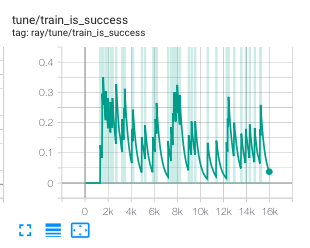

- So somehow between when it was working before and now, the agent stopped being able to learn. The first thing I can try is removing the save/load code, and after that if that doesnt work then doing diffs against the working commit.

- Saving now seems to be creating some bizarre problem due to saving large files..?

- Okay I think that saving and loading everything is too much, I need to be more specific and careful about how I save and load. For now I'm going to NOT worry about being able to restore. I think that performance was bad from_images since the viewer_setup changed each time.

- Damn! I somehow don't have the old commits. For fucks sake!

- I hope the oldest one I have is good to go...

- It turns out the issue was that I set `num_resampled_goals` to 4 (when it was originally 1)... I wonder how well it would work with no resampled goals?

- I just realized that the rewards form the replay buffer can be outdated. Older recorded rewards no longer apply once the critic gets updated. I basically always need to recompute the reward when sampling from the replay buffer.

- I'm going to make a `git commit` before making the changes to fix this

- So I made the change above, but it was actually unnecessary (although it's still readable and barely made a difference).
- I also did some experiments and found that, since the critic was learning, the reward function was changing. I just replaced the env's conv encoder with a frozen copy of the agent's encoder before training, and that was sufficient to learn the task!
- I can actually rewrite things a bit to just create an encoder for the env itself without needing to "set" if from the agent.

- The only problem is that I lose some explainability now... It's not a representation that's "optimized for downstream learning" anymore. That argument was cyclic anyways though.

- Of course the other thing that I can try is to just scale rewards so that the critic can handle them.

- Well that didnt work :P i'm going to try the frozen encoder on the physical robot.

Nov 26
- So I ran it on the physical robot, which took about 25 hours to 20k time steps (!!!). 

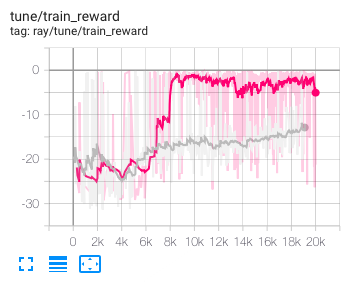

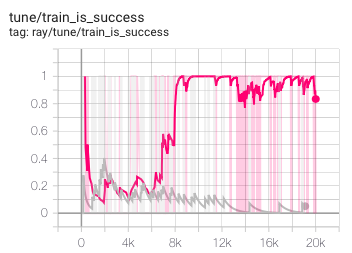

- Strangely, when I actually LOOK at the videos, it seems like the robot isn't completely dumb. The images are definitely close... Not only that, but the robot stops moving once it thinks it gets to the goal position.
- Start of episode:
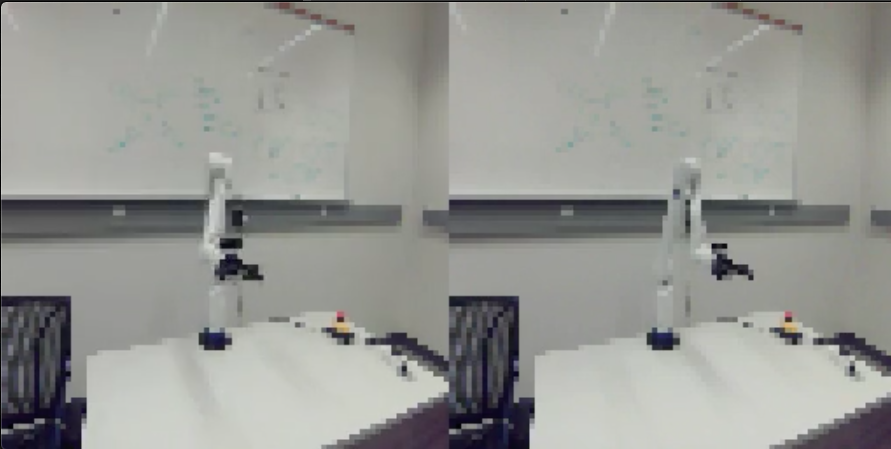
- End of episode:
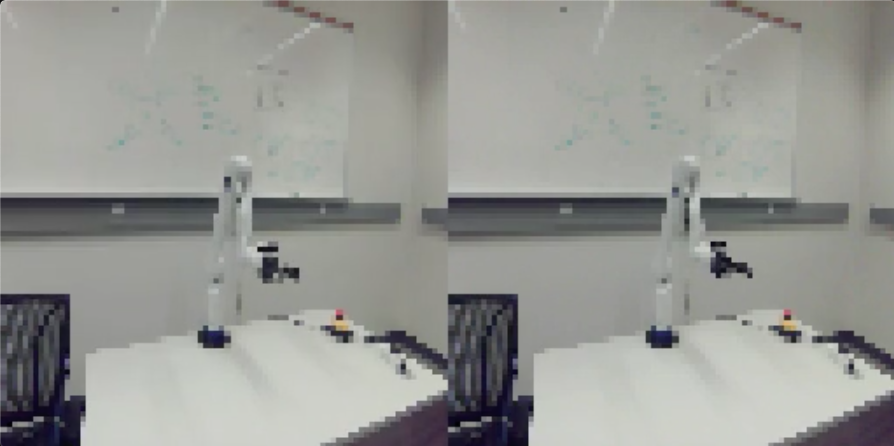

- I think that one thing we could do is to normalize the images by subtracting the mean and dividing by the std (though we would need to remove the part of the image encoder that divides by 255.)
- I think I should turn off those safety zones as well since I didn't fix goal sampling to be legitimate
- The goals may also benefit from being farther away from the starting position

- I just ran a big hyperparameter grid search on the original problem with fixed goals (SAC + states + fixed goals) for FetchPickAndPlace-v1 and got some decent results in some envs by around 300k steps (some even sooner, like 40k steps).

Nov 27
- I re-ran with `fixed_goals=False` and got some good results (but had a "core dumped" error..?)
- It looks like
  - gradient_steps=1
  - lr=0.0005
  - init_temperature=1
  - batch_size=1024
  - critic_tau: 0.0005
  - discount: 0.95
  

- Maybe change evaluation metric as final distance to goal?


In [9]:
from train import Experiment

Kinova not found.


In [10]:
exp = Experiment("FetchReach-v1", from_images=True)

In [ ]:
exp.train()

Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
Session not detected. You should not be calling this function outside `tune.run` or while using the clas

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import torch

In [ ]:
exp.agent.critic = exp.agent.critic.to('cpu')

In [ ]:
def compute_disagreement(observations, desired_goal, actions, i):
    observations = torch.as_tensor(observations, device='cpu').float()
    desired_goal = torch.as_tensor(desired_goal, device='cpu').float()
    actions = torch.as_tensor(actions, device='cpu').float()
    
    desired_goal = desired_goal.clone()
    desired_goal[:] = desired_goal[i]
    Q1, Q2 = exp.agent.critic(observations, desired_goal, actions)
    disagreement = ((Q1 - Q2)**2).mean().item()
#     image = desired_goal[0].cpu().numpy().astype('uint8')
#     plt.figure()
#     plt.title(disagreement.item())
#     plt.imshow(image.T)
    return disagreement

In [ ]:
observations, desired_goal, actions= exp.replay_buffer.observations[-1000:], exp.replay_buffer.desired_goals[-1000:], exp.replay_buffer.actions[-1000:] 

In [ ]:
disagreement = [compute_disagreement(observations, desired_goal, actions, i) for i in range(1_000)]

In [ ]:
for i in range(1_000):
    print(compute_disagreement(observations, desired_goal, actions, i))

In [ ]:
compute_disagreement(observations, desired_goal.clone(), actions, 1)